In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import random

In [3]:
images1 = np.load("cs475_project_data/images.npy")
num_images, height, width = images1.shape
images1 = images1.reshape(num_images, height*width) #reshape
labels1 = np.load("cs475_project_data/labels.npy")

images = torch.from_numpy(images1)
labels = torch.from_numpy(labels1).type(torch.IntTensor) # make sure int values

images = images.type(torch.DoubleTensor)
images = (images - torch.mean(images))/torch.std(images)
# the above normalizes the data based on z score

In [4]:
# split data
train_data = images[:40000]
dev_data = images[40000:45000]
test_data = images[45000:]

train_labels = labels[:40000]
dev_labels = labels[40000:45000]
test_labels = labels[45000:]

HEIGHT = 26
WIDTH = 26
NUM_CLASSES = 5
NUM_OPT_STEPS = 5000

In [5]:
class TwoLayerNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(HEIGHT*WIDTH, 100)
        self.linear2 = torch.nn.Linear(100, NUM_CLASSES)
    def forward(self, x):
        first = F.relu(self.linear1(x)).clamp(min=0)
        y_pred = self.linear2(first)
        return y_pred

In [6]:
model = TwoLayerNN()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [8]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    temp = train_data.numpy()
    temp1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(temp[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(temp1[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [9]:
def approx_train_accuracy():
    i = np.random.choice(train_data.shape[0], size=1000, replace=False)
    tempy = train_data.numpy()
    tempy1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy1[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

def val_accuracy():
    i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

In [122]:
train_accs, val_accs = [], []
iterations = []
print("Using model with initial, unadjusted optimizer and learning rate")
for i in range(NUM_OPT_STEPS):
    train(1)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

Using model with initial, unadjusted optimizer and learning rate
     0  0.20  0.21
   100  0.62  0.61
   200  0.67  0.66
   300  0.70  0.70
   400  0.71  0.69
   500  0.70  0.69
   600  0.68  0.69
   700  0.69  0.69
   800  0.70  0.69
   900  0.72  0.71
  1000  0.70  0.71
  1100  0.70  0.70
  1200  0.71  0.71
  1300  0.74  0.73
  1400  0.71  0.72
  1500  0.72  0.72
  1600  0.72  0.71
  1700  0.70  0.72
  1800  0.72  0.71
  1900  0.72  0.72
  2000  0.71  0.74
  2100  0.73  0.73
  2200  0.77  0.74
  2300  0.72  0.74
  2400  0.74  0.74
  2500  0.74  0.74
  2600  0.74  0.74
  2700  0.75  0.75
  2800  0.76  0.73
  2900  0.74  0.73
  3000  0.75  0.76
  3100  0.73  0.74
  3200  0.75  0.76
  3300  0.77  0.77
  3400  0.75  0.76
  3500  0.74  0.75
  3600  0.72  0.76
  3700  0.78  0.76
  3800  0.75  0.76
  3900  0.75  0.77
  4000  0.74  0.74
  4100  0.77  0.77
  4200  0.78  0.76
  4300  0.77  0.76
  4400  0.78  0.76
  4500  0.76  0.76
  4600  0.77  0.77
  4700  0.78  0.78
  4800  0.76  0.75
  49

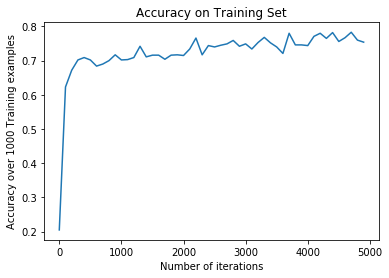

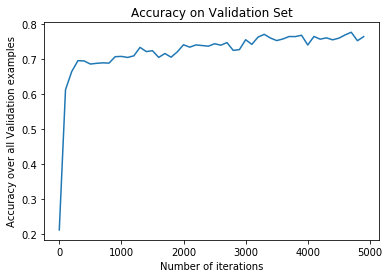

In [123]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

In [28]:
for m in model.children():
    m.reset_parameters()

In [10]:
train_accs, val_accs = [], []
iterations = []
print("Using model with batch size of 10")
for i in range(NUM_OPT_STEPS):
    train(10)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

Using model with batch size of 10
     0  0.30  0.30
   100  0.74  0.74
   200  0.76  0.74
   300  0.77  0.76
   400  0.79  0.77
   500  0.79  0.78
   600  0.81  0.78
   700  0.81  0.79
   800  0.79  0.79
   900  0.79  0.79
  1000  0.80  0.79
  1100  0.79  0.80
  1200  0.79  0.78
  1300  0.82  0.80
  1400  0.82  0.81
  1500  0.82  0.81
  1600  0.82  0.82
  1700  0.84  0.81
  1800  0.83  0.82
  1900  0.82  0.82
  2000  0.83  0.82
  2100  0.83  0.82
  2200  0.82  0.81
  2300  0.84  0.82
  2400  0.84  0.82
  2500  0.81  0.82
  2600  0.85  0.82
  2700  0.84  0.83
  2800  0.87  0.83
  2900  0.84  0.83
  3000  0.83  0.83
  3100  0.84  0.83
  3200  0.85  0.83
  3300  0.85  0.83
  3400  0.88  0.83
  3500  0.86  0.84
  3600  0.87  0.84
  3700  0.86  0.83
  3800  0.85  0.84
  3900  0.85  0.84
  4000  0.86  0.83
  4100  0.87  0.83
  4200  0.85  0.84
  4300  0.87  0.84
  4400  0.85  0.84
  4500  0.86  0.84
  4600  0.87  0.83
  4700  0.86  0.83
  4800  0.87  0.85
  4900  0.86  0.83


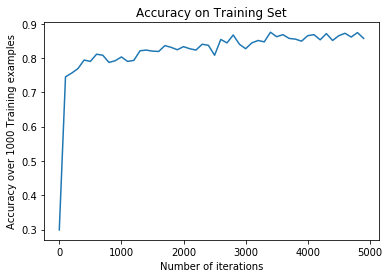

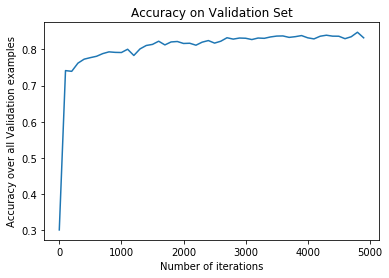

In [11]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

In [12]:
for m in model.children():
    m.reset_parameters()

In [13]:
train_accs, val_accs = [], []
iterations = []
NUM_OPT_STEPS = 1500
print("Using model with batch size of 1000 and total steps of 1500")
for i in range(NUM_OPT_STEPS):
    train(1000)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

Using model with batch size of 1000 and total steps of 1500
     0  0.27  0.26
   100  0.77  0.79
   200  0.83  0.81
   300  0.81  0.82
   400  0.88  0.83
   500  0.87  0.83
   600  0.85  0.84
   700  0.85  0.84
   800  0.86  0.84
   900  0.90  0.85
  1000  0.88  0.85
  1100  0.89  0.85
  1200  0.91  0.85
  1300  0.92  0.85
  1400  0.90  0.86


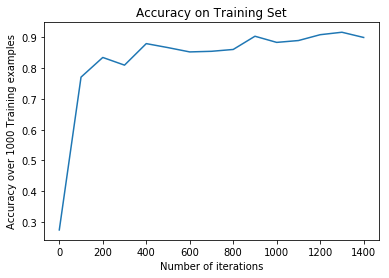

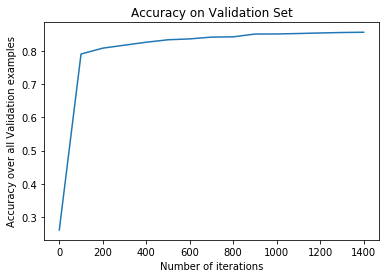

In [15]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

#10: the best validation accuracy I acould achieve was 86% for my simple NN. The batch size was 1000, the learning rate was .001, and I used 1500 optimization steps to reach that accuracy. Training took about a minute. 